In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from sklearn.linear_model import LinearRegression

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [3]:
start_dt = '2021-04-01'
end_dt = '2021-05-05'
change_start_dt = '2021-04-16'
change_end_dt = '2021-04-19'

(1) Did we see new users because of the US West Endpoint? 

(2) Or are we seeing more auctions for the same  users?

(3) Track Gains from new QPS/Endpoint? 

In [4]:
df = bigquery_client.query(f"""
select
    case when ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , date
    , case 
        when date <= '{change_start_dt}' then 0 
        when date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , hosting_app_id
    , request_host
    , tid 
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(id,1) = '0'
    and exchange_id = 41
group by 1,2,3,4,5,6
""").to_dataframe()
df['date'] = df['date'].astype('datetime64')
df['spend'] = df['spend'].astype('float')
df['cost'] = df['cost'].astype('float')
df

buyer       date  with_change  hosting_app_id   request_host  \
0           DT 2021-04-25          1.0         1116483  alw.tpbid.com   
1           DT 2021-05-02          1.0      1498229533  alu.tpbid.com   
2           DT 2021-04-25          1.0          995164  alu.tpbid.com   
3           DT 2021-04-25          1.0         1174132  alu.tpbid.com   
4           DT 2021-04-25          1.0      1139055265  alu.tpbid.com   
...        ...        ...          ...             ...            ...   
10460647   RON 2021-04-24          1.0      1058317706           None   
10460648   RON 2021-05-05          1.0      1530876832  ale.tpbid.com   
10460649   RON 2021-05-05          1.0      1530876832  ale.tpbid.com   
10460650   RON 2021-05-05          1.0       945680681  ale.tpbid.com   
10460651   RON 2021-05-03          1.0      1559030764  alw.tpbid.com   

                                       tid  impressions  clicks  installs  \
0         06b93bc1cdfb00627a7914af2f857e93           48      16         0   
1         021cbeec8abad7bbd2bd37c3623a6ba2           16       0         0   
2         00b02509ffff3b44b6e6c6179a188169           16       0         0   
3         0deebcb84ed169fbab20cdddd8d96981           16       0         0   
4         04b55639bd4d07b0cf0f33bf9bdaa346           16       0         0   
...                                    ...          ...     ...       ...   
10460647  0b95ec7aa57dc85888cf955dfaf6e732           32       0         0   
10460648  0bca15d98b1554a6ee13546e9bd36b35           16       0         0   
10460649  05e67d336a0d512e4980142defe6f3c6           16       0         0   
10460650  0945683c28fd1d398e5442ba30c3cb11           48       0         0   
10460651  0a8bb7f4be89c72af52cb1f635e106d4           16       0         0   

          spend      cost  
0           0.0  0.206112  
1           0.0  0.010384  
2           0.0  0.090320  
3           0.0  0.031360  
4           0.0  0.008064  
...         ...       ...  
10460647    0.0  0.001056  
10460648    0.0  0.002160  
10460649    0.0  0.001104  
10460650    0.0  0.009888  
10460651    0.0  0.003968  

[10460652 rows x 11 columns]

In [5]:
agg_dict = {'request_host':lambda x:len(x.unique())
            ,'impressions':sum
            , 'spend':sum
            , 'cost':sum
            , 'hosting_app_id':lambda x:len(x.unique())
            , 'tid':lambda x:len(x.unique())
           }
pvt = df.pivot_table(values = ['request_host','impressions','spend','hosting_app_id','tid','cost'], index = 'date', aggfunc = agg_dict)
pvt = pvt.join(df[df.tid.isna()].pivot_table(values = 'impressions', index = 'date', aggfunc = sum), rsuffix = '_blanks')
pvt.columns = pvt.columns[:5].to_list() + ['unique_tids','blank_tid_imps']
pvt

cost  hosting_app_id  impressions  request_host     spend  \
date                                                                            
2021-04-09      0.019712               2           16             1      0.00   
2021-04-10      4.569744              62          448             1      0.00   
2021-04-11     12.571872             155         1632             1      0.00   
2021-04-12   9509.479344            6389      4420176             1      0.00   
2021-04-13  17283.951008            7204      6470560             1      0.00   
2021-04-14  19959.055088            7393      7486688             1      0.00   
2021-04-15  18556.038992            7382      7421088             1      0.00   
2021-04-16  16899.865088            7545      7420048             1    652.80   
2021-04-17  17669.172448            7713      7898112             1   4034.40   
2021-04-18  26701.102336            8306     12845408             1  26869.92   
2021-04-19  37749.687056            8649     15918336             1  42560.80   
2021-04-20  42278.822768            8855     18321184             1  44787.20   
2021-04-21  46277.150384            8918     19945856             1  52058.24   
2021-04-22  43088.015744            8894     18538752             3  47234.40   
2021-04-23  43691.484253            9024     18743072             5  51601.92   
2021-04-24  46690.813331            9208     20206928             5  59921.44   
2021-04-25  44712.929357            9300     20688304             5  52230.88   
2021-04-26  45045.386812            9165     19491920             4  51045.28   
2021-04-27  42300.319313            9125     18815024             4  47334.72   
2021-04-28  41955.678738            9161     18893024             4  51709.28   
2021-04-29  47548.166331            9362     19482160             4  56226.72   
2021-04-30  47419.951255            9398     18820592             4  55674.08   
2021-05-01  48098.031842            9653     21186480             4  59627.68   
2021-05-02  50435.018264            9688     22564688             4  62441.76   
2021-05-03  48486.518515            9472     21794656             4  55344.64   
2021-05-04  49596.133528            9462     21014912             4  58870.24   
2021-05-05  54482.754682            9369     22737232             4  65393.76   

            unique_tids  blank_tid_imps  
date                                     
2021-04-09            1            16.0  
2021-04-10            1           448.0  
2021-04-11            1          1632.0  
2021-04-12            1       4420176.0  
2021-04-13            1       6470560.0  
2021-04-14            1       7486688.0  
2021-04-15            1       7421088.0  
2021-04-16            1       7420048.0  
2021-04-17            1       7898112.0  
2021-04-18            9      12845376.0  
2021-04-19          251      15917344.0  
2021-04-20         1084      18313504.0  
2021-04-21       396413       6659776.0  
2021-04-22       533706             NaN  
2021-04-23       535012             NaN  
2021-04-24       561300             NaN  
2021-04-25       580600             NaN  
2021-04-26       555894             NaN  
2021-04-27       542392             NaN  
2021-04-28       533748             NaN  
2021-04-29       555794             NaN  
2021-04-30       547038             NaN  
2021-05-01       611862             NaN  
2021-05-02       640123             NaN  
2021-05-03       618175             NaN  
2021-05-04       597279             NaN  
2021-05-05       647301             NaN

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


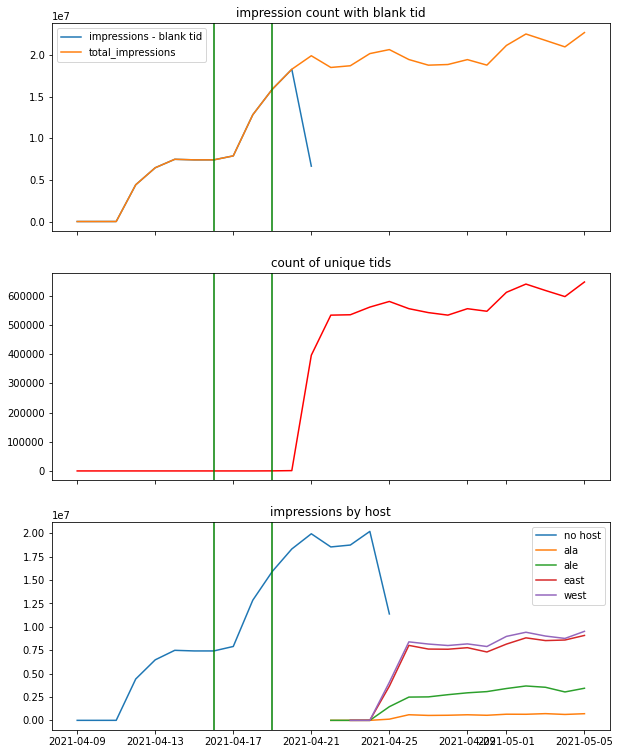

In [6]:
df.pivot_table(values = 'impressions', index = 'date', columns = 'request_host', aggfunc = np.sum)

null_host = df[df.request_host.isnull()].pivot_table(values = ['impressions','tid'], index = 'date', aggfunc = {'impressions':sum, 'tid':lambda x:len(x.unique())})
by_host = df.pivot_table(values = ['impressions','tid'], index = 'date', columns = 'request_host', aggfunc = {'impressions':sum, 'tid':lambda x:len(x.unique())})
by_host = null_host.join(by_host, how = 'outer')
by_host.columns = ['impressions_nohost','unique_users_nohost','impressions_ala','impressions_ale','impressions_east','impressions_west','unique_users_ala','unique_users_ale','unique_users_east','unique_users_west']

fig, ax = plt.subplots(3,1,figsize = (10,13), sharex = True)
ax[0].plot(pvt[['blank_tid_imps','impressions']])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax[0].set_title('impression count with blank tid')
ax[0].legend(['impressions - blank tid', 'total_impressions'])
ax[1].plot(pvt['unique_tids'], color = 'red')
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax[1].set_title('count of unique tids')
ax[2].plot(by_host[['impressions_nohost','impressions_ala','impressions_ale','impressions_east','impressions_west']])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax[2].axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax[2].set_title('impressions by host')
ax[2].legend(['no host','ala','ale','east','west'])

In [7]:
appreciate_data = pd.read_csv('~/Downloads/AppLovin_3.15_4.26.csv')
appreciate_data['Date'] = appreciate_data['Date'].astype('datetime64')
appreciate_data = appreciate_data.loc[appreciate_data.Date >= start_dt].set_index('Date')
appreciate_data.columns = ['us-west_volume','impressions','clicks','cost','lift_pct']
joined = pvt.join(appreciate_data, rsuffix = '_apprec')

fig, ax = plt.subplots(3,1, figsize = (10,15))
ax[0].plot(joined[['impressions','impressions_apprec']])
ax[0].set_title('BQ data lags behind appreciate metrics until 4/19')
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax[0].legend(['impressions_bq','impressions_apprec'])
ax[1].plot(joined[['cost','cost_apprec']])
ax[1].legend(['cost_bq','cost_apprec'])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax[2].plot(joined[['cost','cost_apprec','spend']])
ax[2].legend(['cost_bq','cost_apprec','rev_bq'])
ax[2].axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax[2].axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax[2].set_title('BigQuery cost and rev')

Text(0.5, 1.0, 'BigQuery cost and rev')

Text(0.5, 1.0, 'BigQuery cost and rev')

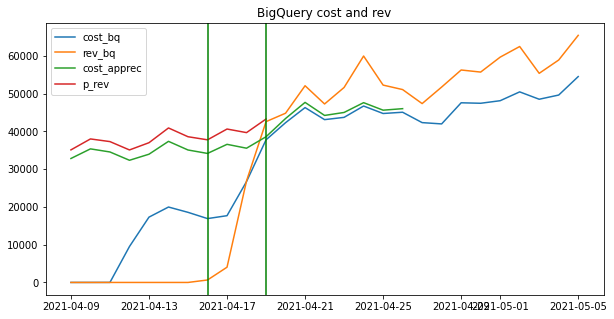

In [8]:
joined['margin'] = np.where(joined.index >= pd.to_datetime(change_end_dt), (joined.spend-joined.cost)/joined.spend,np.nan)
model = LinearRegression()
train = joined.loc[joined.index >= pd.to_datetime(change_end_dt)]
x_train = (train.index - train.index[0]).days.values.reshape(-1,1)
y_train = train['margin']
model.fit(x_train,y_train)

predicted_margin = model.predict((joined.index - train.index[0]).days.values.reshape(-1,1))
joined['p_margin'] = predicted_margin
joined['p_rev'] = np.where(joined.index <= pd.to_datetime(change_end_dt), joined['cost_apprec']/(1-joined['p_margin']), np.nan)

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(joined[['cost','spend','cost_apprec','p_rev']])
ax.legend(['cost_bq','rev_bq','cost_apprec','p_rev'])
ax.axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax.axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax.set_title('BigQuery cost and rev')

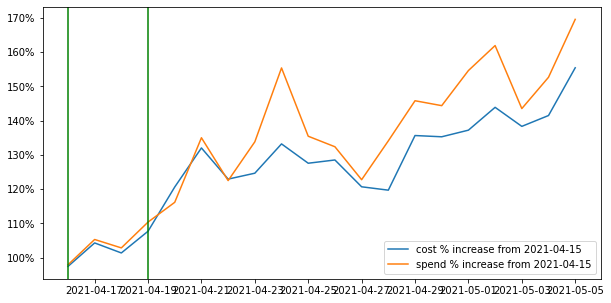

In [9]:
base_date = pd.to_datetime(change_start_dt) - datetime.timedelta(days = 1)
base_spend = float(joined.loc[joined.index == base_date,'p_rev'])
base_cost = float(joined.loc[joined.index == base_date,'cost_apprec'])

joined['spend_pct_increase'] = np.where(joined.index < pd.to_datetime(change_start_dt),np.nan
                                        ,np.where(joined.index >= pd.to_datetime(change_end_dt),joined['spend'],joined['p_rev'])/base_spend
                                       )
joined['cost_pct_increase'] = np.where(joined.index < pd.to_datetime(change_start_dt),np.nan
                                        ,np.where(joined.index >= pd.to_datetime(change_end_dt),joined['cost'],joined['cost_apprec'])/base_cost
                                       )
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(100*joined[['cost_pct_increase', 'spend_pct_increase']])
ax.axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax.axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax.legend(['cost % increase from {}'.format(base_date.strftime('%Y-%m-%d')),'spend % increase from {}'.format(base_date.strftime('%Y-%m-%d'))])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [10]:
non_al = bigquery_client.query(f"""
select
    case when ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , date
    , case 
        when date <= '{change_start_dt}' then 0 
        when date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(id,1) = '0'
    and exchange_id != 41
group by 1,2,3
""").to_dataframe()

<ipython-input-11-8cb948068b8d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  non_al_byday = non_al.groupby('date')['spend','cost'].sum()


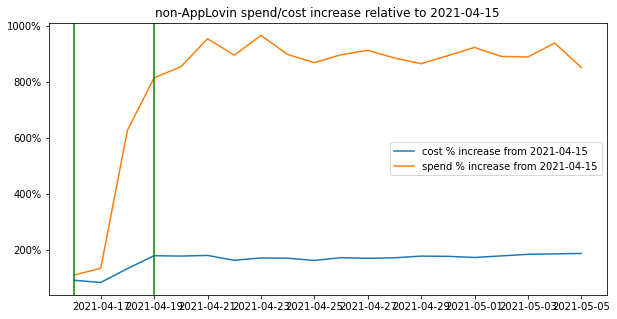

In [11]:
non_al_byday = non_al.groupby('date')['spend','cost'].sum()
non_al_byday.index = non_al_byday.index.astype('datetime64[ns]')
non_al_byday['spend'] = non_al_byday['spend'].astype('float')
non_al_byday['cost'] = non_al_byday['cost'].astype('float')

base_spend = float(non_al_byday.loc[non_al_byday.index == base_date,'spend'])
base_cost = float(non_al_byday.loc[non_al_byday.index == base_date,'cost'])


non_al_byday['spend_pct_increase'] = np.where(non_al_byday.index < pd.to_datetime(change_start_dt),np.nan
                                        ,non_al_byday['spend']/base_spend
                                       )
non_al_byday['cost_pct_increase'] = np.where(non_al_byday.index < pd.to_datetime(change_start_dt),np.nan
                                        ,non_al_byday['cost']/base_cost
                                       )

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(100*non_al_byday[['cost_pct_increase', 'spend_pct_increase']])
ax.axvline(x = pd.to_datetime(change_start_dt), color = 'green')
ax.axvline(x = pd.to_datetime(change_end_dt), color = 'green')
ax.legend(['cost % increase from {}'.format(base_date.strftime('%Y-%m-%d')),'spend % increase from {}'.format(base_date.strftime('%Y-%m-%d'))])
ax.set_title('non-AppLovin spend/cost increase relative to '+(base_date.strftime('%Y-%m-%d')))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

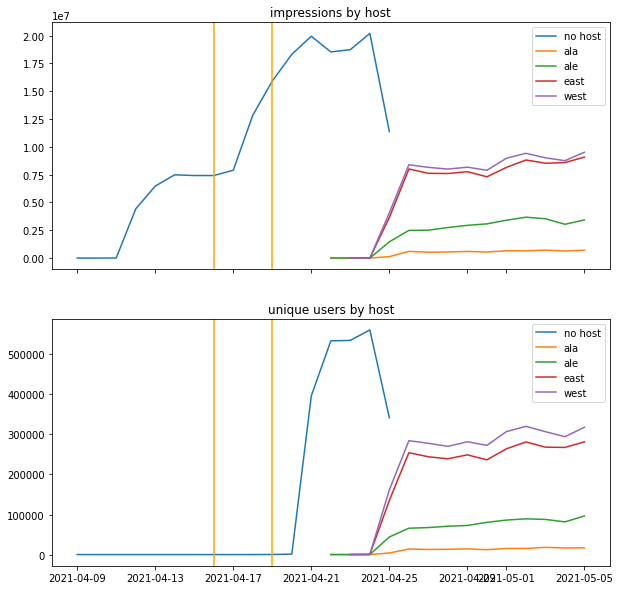

In [12]:
fig, ax = plt.subplots(2,1,figsize = (10,10), sharex = True)
ax[0].plot(by_host[['impressions_nohost','impressions_ala','impressions_ale','impressions_east','impressions_west']])
ax[0].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[0].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[0].set_title('impressions by host')
ax[0].legend(['no host','ala','ale','east','west'])
ax[1].plot(by_host[['unique_users_nohost','unique_users_ala','unique_users_ale','unique_users_east','unique_users_west']])
ax[1].axvline(x = pd.to_datetime(change_start_dt), color = 'orange')
ax[1].axvline(x = pd.to_datetime(change_end_dt), color = 'orange')
ax[1].set_title('unique users by host')
ax[1].legend(['no host','ala','ale','east','west'])

In [13]:
sov_byhost = df[df.date >= pd.to_datetime('2021-04-25')].pivot_table(values = ['impressions','spend','cost'], index = 'request_host', aggfunc = np.sum)
sov_byhost['cost_sov'] = sov_byhost['cost']/sov_byhost['cost'].sum()
sov_byhost['impressions_sov'] = sov_byhost['impressions']/sov_byhost['impressions'].sum()
sov_byhost['spend_sov'] = sov_byhost['spend']/sov_byhost['spend'].sum()
round(sov_byhost[['cost_sov','spend_sov','impressions_sov']],2).sort_values('spend_sov', ascending = False)

cost_sov  spend_sov  impressions_sov
request_host                                       
alu.tpbid.com      0.51       0.53             0.40
alw.tpbid.com      0.47       0.46             0.42
ale.tpbid.com      0.02       0.01             0.15
ala.tpbid.com      0.00       0.00             0.03

In [14]:
west = df[(df.date >= '2021-04-26') & (df.request_host == 'alw.tpbid.com')].pivot_table(values = 'impressions', index = ['date','tid'], aggfunc = np.sum)
east = df[(df.date >= '2021-04-26') & (df.request_host == 'alu.tpbid.com')].pivot_table(values = 'impressions', index = ['date','tid'], aggfunc = np.sum)

west_east = west.join(east, how = 'outer', lsuffix = '_west', rsuffix = '_east')
both_imps = west_east[(west_east.impressions_west > 0) & (west_east.impressions_east > 0)].reset_index()
user_overlap = both_imps.pivot_table(values = 'tid', index = 'date', aggfunc = lambda x:len(x.unique()))
west_users = west[west.impressions > 0].reset_index().pivot_table(values = 'tid', index = 'date', aggfunc = lambda x:len(x.unique()))
east_users = east[east.impressions > 0].reset_index().pivot_table(values = 'tid', index = 'date', aggfunc = lambda x:len(x.unique()))
combined_users = west_users.join(east_users, how = 'outer', lsuffix='_west',rsuffix='_east').join(user_overlap, how = 'outer', rsuffix='_combined')
combined_users.columns = ['unique_imps_west','unique_imps_east','overlap_users']
combined_users['avg_overlap'] = combined_users['overlap_users']/((combined_users['unique_imps_west'] + combined_users['unique_imps_east'])/2)
combined_users

unique_imps_west  unique_imps_east  overlap_users  avg_overlap
date                                                                      
2021-04-26            282793            253204          59699     0.222759
2021-04-27            276239            242997          56774     0.218683
2021-04-28            268610            238039          56185     0.221791
2021-04-29            279864            247668          57826     0.219232
2021-04-30            270910            235198          51161     0.202174
2021-05-01            305289            262860          57577     0.202683
2021-05-02            318325            280149          62454     0.208711
2021-05-03            305161            267048          59244     0.207071
2021-05-04            292594            266302          59719     0.213703
2021-05-05            316151            280389          62096     0.208187

In [15]:
filters = (df.date < '2021-04-26') & (df.request_host.isna()) & (df.impressions > 0) & (~df.tid.isna())
no_host = pd.DataFrame({'tid_existing':df.loc[filters, 'tid'].unique()})

west_existing = pd.merge(west.reset_index(), no_host, left_on = 'tid', right_on = 'tid_existing', how = 'left')
west_existing_ct = west_existing.pivot_table(values = ['tid', 'tid_existing'], index = 'date', aggfunc = lambda x:len(x.unique()))
west_existing_ct['pct_existing'] = west_existing_ct['tid_existing']/west_existing_ct['tid']

east_existing = pd.merge(east.reset_index(), no_host, left_on = 'tid', right_on = 'tid_existing', how = 'left')
east_existing_ct = east_existing.pivot_table(values = ['tid', 'tid_existing'], index = 'date', aggfunc = lambda x:len(x.unique()))
east_existing_ct['pct_existing'] = east_existing_ct['tid_existing']/east_existing_ct['tid']

total_existing_ct = east_existing_ct.join(west_existing_ct, lsuffix = '_east', rsuffix = '_west')
total_existing_ct

tid_east  tid_existing_east  pct_existing_east  tid_west  \
date                                                                   
2021-04-26    254365             142007           0.558280    284396   
2021-04-27    244200             128634           0.526757    277915   
2021-04-28    239228             121308           0.507081    270270   
2021-04-29    249023             118214           0.474711    281740   
2021-04-30    236580             106821           0.451522    272751   
2021-05-01    264122             107454           0.406835    307141   
2021-05-02    281302             108577           0.385980    320185   
2021-05-03    268219             104850           0.390912    306918   
2021-05-04    267557             103810           0.387992    294466   
2021-05-05    281569             103232           0.366631    317918   

            tid_existing_west  pct_existing_west  
date                                              
2021-04-26             161283           0.567107  
2021-04-27             146491           0.527107  
2021-04-28             136583           0.505358  
2021-04-29             132850           0.471534  
2021-04-30             122110           0.447698  
2021-05-01             122870           0.400044  
2021-05-02             123094           0.384446  
2021-05-03             117843           0.383956  
2021-05-04             113980           0.387074  
2021-05-05             114385           0.359794

<AxesSubplot:title={'center':'existing vs. total users by day'}, xlabel='date'>

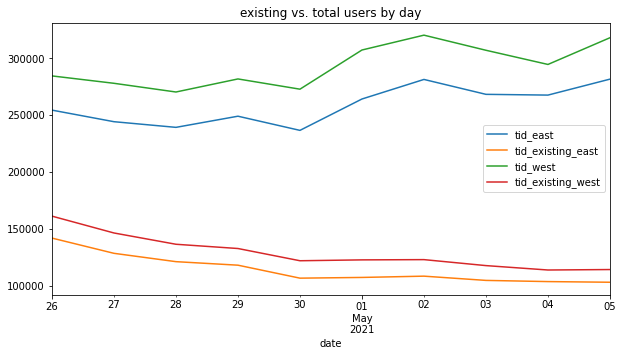

In [16]:
total_existing_ct[['tid_east','tid_existing_east','tid_west','tid_existing_west']].plot(figsize = (10,5), title = 'existing vs. total users by day')

In [17]:
by_zip = bigquery_client.query(f"""
select
    case when ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , date
    , case 
        when date <= '{change_start_dt}' then 0 
        when date >= '{change_end_dt}' then 1
    else NULL end as with_change
    , country
    , zipcode
    , city
    , request_host
    , sum(case when event_type = 'clear' then 1 else 0 end) as impressions
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(id,1) = '0'
    and exchange_id = 41
group by 1,2,3,4,5,6,7
""").to_dataframe()
by_zip['impressions'] = by_zip['impressions'].astype('int')
by_zip['spend'] = by_zip['spend'].astype(float)
by_zip['cost'] = by_zip['cost'].astype(float)
by_zip['zipcode'] = by_zip['zipcode'].astype('string')

In [18]:
by_zip['blank_zip_code'] = by_zip.zipcode.isna()
by_zip['blank_city'] = by_zip.city.isna()
by_zip[by_zip.date >= pd.to_datetime(change_end_dt)].pivot_table(values = 'impressions', index = ['request_host','blank_zip_code','blank_city'], aggfunc = np.sum)

impressions
request_host  blank_zip_code blank_city             
ala.tpbid.com False          False              2177
              True           False            391612
                             True                345
ale.tpbid.com True           False           2018724
alu.tpbid.com True           False           5321128
alw.tpbid.com True           False           5648620

In [19]:
by_zip.pivot_table(values = ['impressions','zipcode'], index = 'date', aggfunc = {'impressions':sum, 'zipcode':lambda x:len(x.isna())})

impressions  zipcode
date                            
2021-04-09            1        1
2021-04-10           28       74
2021-04-11          102      192
2021-04-12       276261    23343
2021-04-13       404410    27037
2021-04-14       467918    28283
2021-04-15       463818    27464
2021-04-16       463753    28200
2021-04-17       493632    29010
2021-04-18       802838    32972
2021-04-19       994896    34672
2021-04-20      1145074    35484
2021-04-21      1246616    36132
2021-04-22      1158672    35361
2021-04-23      1171442    36703
2021-04-24      1262933    35988
2021-04-25      1293019    71536
2021-04-26      1218245    54003
2021-04-27      1175939    53395
2021-04-28      1180814    53509
2021-04-29      1217635    53848
2021-04-30      1176287    53478
2021-05-01      1324155    55546
2021-05-02      1410293    57456
2021-05-03      1362166    58067
2021-05-04      1313432    56481
2021-05-05      1421077    60080

In [20]:
pvt_country = by_zip.pivot_table(values = 'impressions', index = 'country', columns = 'with_change', aggfunc = np.sum, margins = True)
pvt_country.div(pvt_country.iloc[-1], axis = 1).iloc[:-1,:2].sort_values(1, ascending = False)

with_change       0.0       1.0
country                        
US           0.484084  0.466453
BR           0.160358  0.170479
MX           0.044933  0.133967
GB           0.143084  0.106067
AR           0.012297  0.022717
DE           0.027214  0.020996
CA           0.024294  0.020243
FR           0.025632  0.015489
KR           0.030231  0.013525
AU           0.012855  0.008630
NL           0.004460  0.002687
UA           0.003185  0.002508
ID           0.002979  0.002362
RU           0.001873  0.001815
SE           0.002639  0.001537
ES           0.009739  0.001343
BY           0.001529  0.001171
DZ                NaN  0.001169
CL           0.000763  0.001102
BE                NaN  0.000963
ZA           0.000785  0.000833
EG           0.002406  0.000783
JP                NaN  0.000607
NO           0.000752  0.000533
IN           0.000975  0.000458
CO           0.000260  0.000400
TN           0.000693  0.000347
CI           0.000573  0.000304
SA           0.000533  0.000197
IQ           0.000301  0.000143
PK           0.000201  0.000079
FI           0.000209  0.000077
TH                NaN  0.000007
MA           0.000002  0.000004
OM           0.000003  0.000004
PL           0.000158       NaN

In [21]:
zip_key = pd.read_csv('files/uszips.csv')
zip_key['zip'] = zip_key['zip'].astype('string')
by_zip_merged = pd.merge(by_zip[by_zip.country == 'US'], zip_key, left_on = 'zipcode', right_on = 'zip', how = 'left')

In [22]:
pvt_tz = by_zip_merged.pivot_table(values = 'impressions', index = 'timezone', columns = 'with_change', aggfunc = np.sum, margins = True)
pvt_tz.div(pvt_tz.iloc[-1], axis = 1).iloc[:-1,:2].sort_values(1, ascending = False)

with_change                        1.0       All
timezone                                        
America/New_York              0.445511  0.445511
America/Chicago               0.341330  0.341330
America/Los_Angeles           0.095271  0.095271
America/Denver                0.040439  0.040439
America/Detroit               0.039753  0.039753
America/Phoenix               0.019191  0.019191
America/Indiana/Indianapolis  0.010966  0.010966
America/Boise                 0.004798  0.004798
America/Kentucky/Louisville   0.001371  0.001371
America/Indiana/Vincennes     0.000685  0.000685
Pacific/Honolulu              0.000685  0.000685

In [23]:
print(by_zip_merged[(by_zip_merged.request_host == 'alw.tpbid.com')].groupby('blank_zip_code')['impressions'].sum())
print(by_zip_merged[(by_zip_merged.request_host == 'alu.tpbid.com')].groupby('blank_zip_code')['impressions'].sum())

blank_zip_code
True    2522048
Name: impressions, dtype: int64
blank_zip_code
True    3695771
Name: impressions, dtype: int64


### State


In [24]:
state_key = pd.read_csv('files/tz_bystate.csv')
state_key = state_key.groupby('State Code')['STANDARD'].max()
by_zip_merged['state'] = by_zip_merged['city_x'].str[-2:].str.upper()
by_zip_merged = pd.merge(by_zip_merged, state_key, how = 'left', left_on = 'state', right_on = 'State Code', suffixes = ('','_state'))
by_zip_merged

KeyError: 'Column not found: STANDARD'

In [ ]:
imps_byhost_bystate = by_zip_merged.pivot_table(values = 'impressions', index = ['state','UTC offset'], columns = 'request_host', aggfunc = np.sum, margins = True)
imps_byhost_bystate['pct_west'] = round(imps_byhost_bystate['alw.tpbid.com']/imps_byhost_bystate['All'],2)
# imps_byhost_bystate.drop('ala.tpbid.com', inplace = True, axis = 1)
imps_byhost_bystate[imps_byhost_bystate.pct_west < .3].sort_values('All', ascending = False)

In [ ]:
imps_byhost_bytz = by_zip_merged.pivot_table(values = 'impressions', index = ['UTC offset'], columns = 'request_host', aggfunc = np.sum, margins = True)
imps_byhost_bytz['pct_west'] = round(imps_byhost_bytz['alw.tpbid.com']/imps_byhost_bytz['All'],2)
imps_byhost_bytz[imps_byhost_bytz.index != 'All'].sort_values('pct_west', ascending = False)


In [ ]:
imps_byhost_bytz.loc[imps_byhost_bytz.index != 'All',['alu.tpbid.com','alw.tpbid.com']].plot(figsize = (10,5))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.hist(100*imps_byhost_bystate['pct_west'])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Distribution of states by percentage of impressions in West endpoint')